### 0. Initizalize Packages

In [270]:
#!pip install scipy,seaborn
import seaborn as sns
from scipy.stats import kstest
import statsmodels.api as sm


import pandas as pd
import numpy as np


#!pip install -U plotly
pd.options.plotting.backend = "plotly"

#!pip3 install nltk
import nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from scipy.stats import chi2_contingency

import math
from scipy.stats import shapiro 
from scipy.stats import lognorm
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind
from statsmodels.stats.weightstats import ztest as ztest
import statsmodels


#!pip3 install openpyxl
import openpyxl as px
from statsmodels.stats.weightstats import ztest

### 0.1. Read Dataset ( N = 114)

In [271]:
df = pd.read_excel('all_gpt_human_only_text.xlsx')

### 0.1.1 Preprocess

Get rid of extra white spaces

In [272]:
def strip(dataframe):
    return [s.strip() for s in dataframe]

df= df.apply(strip)

## 1. Pos Tagging with Only Negation Adverbs

Each story's pos taggings completed separately, and counted for the story itself

In [273]:
def tokenize_with_negation_only(text):
    tokenized_dict = {}
    tokenized = word_tokenize(text)
    tagged = nltk.pos_tag(tokenized)

    to_remove = set()
    for i in range(len(tagged)):
        if tagged[i][1] in {'RB', 'RBS', 'WRB', 'RBR'} and tagged[i][0].lower() in {'not', "n't"}:
            pass
        elif tagged[i][1] in {'RB', 'RBS', 'WRB','RBR'} and tagged[i][0].lower() not in {'not', "n't"}:
            to_remove.add(i)

        new_tagged = [tagged[i] for i in range(len(tagged)) if i not in to_remove]        

    return new_tagged

In [274]:
## Filter and get words as tokens
for column in df.columns:
    df[f'tokenized_{column}'] = df[column].apply(lambda x: tokenize_with_negation_only(x))

### 1.2. Count the pos-tags

In [275]:
#count the tags
def count_tags(mydata):
    counter_list=[]
    for i in mydata:
        counter_list.append(i[1])

    tag_counts = Counter(counter_list) 
    return tag_counts

In [276]:
for column in [col for col in df.columns if col.startswith('tokenized_')]:
    df[f'{column}_tag_counts'] = df[column].apply(lambda x: count_tags(x))

In [277]:
df.tokenized_STORY_tag_counts

0      {'DT': 16, 'NN': 23, 'WP': 3, 'VBD': 11, 'IN':...
1      {'NNP': 4, 'VBD': 14, 'VBG': 7, 'JJ': 9, 'CD':...
2      {'DT': 20, 'NNP': 3, 'VBD': 17, 'TO': 7, 'VB':...
3      {'DT': 14, 'IN': 14, 'PRP$': 2, 'NN': 22, ',':...
4      {'VBP': 7, 'PRP': 26, 'VBD': 18, 'DT': 11, 'NN...
                             ...                        
111    {'NNP': 6, 'VBZ': 4, 'PRP$': 6, 'NN': 29, '``'...
112    {'EX': 1, 'VBD': 19, 'DT': 31, 'NN': 36, 'WP':...
113    {'EX': 1, 'VBD': 18, 'DT': 20, 'NN': 32, 'WP':...
114    {'CD': 1, 'NN': 30, 'DT': 18, 'VBD': 12, 'VBG'...
115    {'DT': 15, 'NN': 24, 'VBD': 12, 'IN': 16, 'JJ'...
Name: tokenized_STORY_tag_counts, Length: 116, dtype: object

### 1.3. Merge relevant categories together

Count tags for all nouns (plural nouns, proper nouns etc.), verbs, adjectives, adverbs, pronouns and prepositions/conjuctions/determiners


In [278]:
for column in [col for col in df.columns if col.endswith('tag_counts')]:
    df[f'{column[:-7]}_noun'] = [*(df[column].apply(lambda x: (x['NN'] + x['NNS'] + x['NNP']+ x['NNPS'])))]
    df[f'{column[:-7]}_verb'] = [*(df[column].apply(lambda x: (x['VB'] + x['VBN'] + x['VBG']+ x['VBZ'] + x['VBP']+x['VBD'])))]
    df[f'{column[:-7]}_adj'] = [*(df[column].apply(lambda x: (x['JJ'] + x['JJS'] + x['JJR'])))]
    df[f'{column[:-7]}_adv'] = [*(df[column].apply(lambda x: (x['RB'] + x['RBR'] + x['WRB'] + + x['RBS'])))]
    df[f'{column[:-7]}_pron'] = [*(df[column].apply(lambda x: (x['PRP'] + x['PRP$'] + x['WB']+ x['WB$'])))]
    df[f'{column[:-7]}_con_det_prep'] = [*(df[column].apply(lambda x: (x['DT'] + x['IN'] + x['UH']+ x['TO']+ x['WDT']+ x['EX'])))]
    df[f'{column[:-7]}_prep'] = [*(df[column].apply(lambda x: (x['IN'])))]



In [279]:
#Double check with other code (Investigate_adverbs) whether the sums are same
df['tokenized_Retell_1_tag_adv'].sum() + df['tokenized_Retell_2_tag_adv'].sum()+ df['tokenized_Retell_3_tag_adv'].sum()



201

## 1.4. Get Ratio of Grammatical Categories to Word Count

In [280]:
cols = [('tokenized_GPT_R3', 'GPT_3'), 
        ('tokenized_GPT_R2', 'GPT_2'), 
        ('tokenized_GPT_R1', 'GPT_1'), 
        ('tokenized_Retell_1', 'Retell_1'), 
        ('tokenized_Retell_2', 'Retell_2'), 
        ('tokenized_Retell_3', 'Retell_3'), 
        ('tokenized_STORY', 'story')]

# Define a list of tuples with the tag types and their corresponding suffixes
tag_types = [('tag_noun', 'noun'), 
             ('tag_verb', 'verb'), 
             ('tag_adj', 'adj'), 
             ('tag_adv', 'adv'), 
             ('tag_con_det_prep', 'con_det_prep'), 
             ('tag_pron', 'pron'), 
             ('tag_prep', 'prep')]

# Loop over each tag type
for tag_type, suffix in tag_types:
    # Loop over each column and calculate the corresponding tag ratio
    for col, col_suffix in cols:
        tag_col = col + '_' + tag_type
        ratio_col = col_suffix + '_' + suffix + '_ratio'
        df[ratio_col] = df[tag_col] / df[col].apply(len)

/var/folders/l4/1xnf5c593754ph42_t0k68480000gq/T/ipykernel_12283/4017749826.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ratio_col] = df[tag_col] / df[col].apply(len)
/var/folders/l4/1xnf5c593754ph42_t0k68480000gq/T/ipykernel_12283/4017749826.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ratio_col] = df[tag_col] / df[col].apply(len)
/var/folders/l4/1xnf5c593754ph42_t0k68480000gq/T/ipykernel_12283/4017749826.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

### 1.4.1. Carry counts and ratios into different DataFrame

In [281]:
count_ratio = pd.DataFrame

count_ratio= df[['GPT_3_noun_ratio',
 'GPT_2_noun_ratio',
 'GPT_1_noun_ratio',
 'Retell_1_noun_ratio',
 'Retell_2_noun_ratio',
 'Retell_3_noun_ratio',
 'story_noun_ratio',
 'GPT_3_verb_ratio',
 'GPT_2_verb_ratio',
 'GPT_1_verb_ratio',
 'Retell_1_verb_ratio',
 'Retell_2_verb_ratio',
 'Retell_3_verb_ratio',
 'story_verb_ratio',
 'GPT_3_adj_ratio',
 'GPT_2_adj_ratio',
 'GPT_1_adj_ratio',
 'Retell_1_adj_ratio',
 'Retell_2_adj_ratio',
 'Retell_3_adj_ratio',
 'story_adj_ratio',
 'GPT_3_adv_ratio',
 'GPT_2_adv_ratio',
 'GPT_1_adv_ratio',
 'Retell_1_adv_ratio',
 'Retell_2_adv_ratio',
 'Retell_3_adv_ratio',
 'story_adv_ratio',
 'GPT_3_con_det_prep_ratio',
 'GPT_2_con_det_prep_ratio',
 'GPT_1_con_det_prep_ratio',
 'Retell_1_con_det_prep_ratio',
 'Retell_2_con_det_prep_ratio',
 'Retell_3_con_det_prep_ratio',
 'story_con_det_prep_ratio',
 'GPT_3_pron_ratio',
 'GPT_2_pron_ratio',
 'GPT_1_pron_ratio',
 'Retell_1_pron_ratio',
 'Retell_2_pron_ratio',
 'Retell_3_pron_ratio',
 'story_pron_ratio',
 'GPT_3_prep_ratio',
 'GPT_2_prep_ratio',
 'GPT_1_prep_ratio',
 'Retell_1_prep_ratio',
 'Retell_2_prep_ratio',
 'Retell_3_prep_ratio',
 'story_prep_ratio']]

In [282]:
#store counts into a dataframe 
counts = pd.DataFrame()

df_count = df[['tokenized_STORY_tag_noun',
 'tokenized_STORY_tag_verb',
 'tokenized_STORY_tag_adj',
 'tokenized_STORY_tag_adv',
 'tokenized_STORY_tag_pron',
 'tokenized_STORY_tag_con_det_prep',
 'tokenized_STORY_tag_prep',
 'tokenized_GPT_R1_tag_noun',
 'tokenized_GPT_R1_tag_verb',
 'tokenized_GPT_R1_tag_adj',
 'tokenized_GPT_R1_tag_adv',
 'tokenized_GPT_R1_tag_pron',
 'tokenized_GPT_R1_tag_con_det_prep',
 'tokenized_GPT_R1_tag_prep',
 'tokenized_GPT_R2_tag_noun',
 'tokenized_GPT_R2_tag_verb',
 'tokenized_GPT_R2_tag_adj',
 'tokenized_GPT_R2_tag_adv',
 'tokenized_GPT_R2_tag_pron',
 'tokenized_GPT_R2_tag_con_det_prep',
 'tokenized_GPT_R2_tag_prep',
 'tokenized_GPT_R3_tag_noun',
 'tokenized_GPT_R3_tag_verb',
 'tokenized_GPT_R3_tag_adj',
 'tokenized_GPT_R3_tag_adv',
 'tokenized_GPT_R3_tag_pron',
 'tokenized_GPT_R3_tag_con_det_prep',
 'tokenized_GPT_R3_tag_prep',
 'tokenized_Retell_1_tag_noun',
 'tokenized_Retell_1_tag_verb',
 'tokenized_Retell_1_tag_adj',
 'tokenized_Retell_1_tag_adv',
 'tokenized_Retell_1_tag_pron',
 'tokenized_Retell_1_tag_con_det_prep',
 'tokenized_Retell_1_tag_prep',
 'tokenized_Retell_2_tag_noun',
 'tokenized_Retell_2_tag_verb',
 'tokenized_Retell_2_tag_adj',
 'tokenized_Retell_2_tag_adv',
 'tokenized_Retell_2_tag_pron',
 'tokenized_Retell_2_tag_con_det_prep',
 'tokenized_Retell_2_tag_prep',
 'tokenized_Retell_3_tag_noun',
 'tokenized_Retell_3_tag_verb',
 'tokenized_Retell_3_tag_adj',
 'tokenized_Retell_3_tag_adv',
 'tokenized_Retell_3_tag_pron',
 'tokenized_Retell_3_tag_con_det_prep',
 'tokenized_Retell_3_tag_prep']]



Our dataframes are:

1-count = df_count
2- ratio = count_ratio

### 1.5. Significance Test Between Retellings (Counts of Words)

In [283]:
shapiro(df_count) #data is not normal, so we will use Mann-u Whitney

/Users/eotenen/mambaforge/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.83409184217453, pvalue=0.0)

In [284]:
df_count.tokenized_Retell_1_tag_adv

0      1
1      0
2      1
3      1
4      0
      ..
111    0
112    0
113    0
114    1
115    0
Name: tokenized_Retell_1_tag_adv, Length: 116, dtype: int64

In [285]:
for i in range(1, 4):
    group1 = df_count[f'tokenized_GPT_R{i}_tag_adv']
    group2 = df_count[f'tokenized_Retell_{i}_tag_adv']
    statistic, pvalue = stats.mannwhitneyu(group1, group2)
    if pvalue < 0.05:
        print(f"Mann-Whitney U test for GPT_R{i} vs. Retell_{i} is significant with p-value {pvalue}, and stat {statistic}")
    else:
        print(f"Mann-Whitney U test for GPT_R{i} vs. Retell_{i} is not significant with p-value {pvalue}, and stat {statistic}")


Mann-Whitney U test for GPT_R1 vs. Retell_1 is significant with p-value 3.295001170365404e-06, and stat 4692.5
Mann-Whitney U test for GPT_R2 vs. Retell_2 is significant with p-value 0.000138704754808258, and stat 5168.0
Mann-Whitney U test for GPT_R3 vs. Retell_3 is significant with p-value 4.571222675942299e-05, and stat 5147.0


In [286]:
for i in range(1, 4):
    gpt =(df_count[f'tokenized_GPT_R{i}_tag_adv'].mean())
    human = (df_count[f'tokenized_Retell_{i}_tag_adv'].mean())
    print(f'human: {human,i}, gpt: {gpt,i}')

human: (0.7241379310344828, 1), gpt: (0.2672413793103448, 1)
human: (0.5603448275862069, 2), gpt: (0.20689655172413793, 2)
human: (0.4482758620689655, 3), gpt: (0.15517241379310345, 3)


In [287]:
# Total negations of CHATGPT

total_neg_gpt = df_count.tokenized_GPT_R1_tag_adv.sum() + df_count.tokenized_GPT_R2_tag_adv.sum() + df_count.tokenized_GPT_R3_tag_adv.sum()


total_neg_human = df_count.tokenized_Retell_1_tag_adv.sum()+ df_count.tokenized_Retell_2_tag_adv.sum()+df_count.tokenized_Retell_3_tag_adv.sum()


print(f'In total, humans use {total_neg_human} negations, while ChatGPT uses {total_neg_gpt} negations.')


In total, humans use 201 negations, while ChatGPT uses 73 negations.


Still adverb use is higher in human than GPT

### 1.6. Visualize Counts

Prepare dataset accordingly

In [288]:
count_means = pd.DataFrame()
count_means['mean'] = [*df_count.mean()]
count_means['gen']= ['origin','origin','origin','origin','origin','origin','origin','GPT_R1','GPT_R1','GPT_R1','GPT_R1','GPT_R1','GPT_R1','GPT_R1','GPT_R2','GPT_R2','GPT_R2','GPT_R2','GPT_R2','GPT_R2','GPT_R2','GPT_R3','GPT_R3','GPT_R3','GPT_R3','GPT_R3','GPT_R3','GPT_R3','Retell_1','Retell_1','Retell_1','Retell_1','Retell_1','Retell_1','Retell_1','Retell_2','Retell_2','Retell_2','Retell_2','Retell_2','Retell_2','Retell_2','Retell_3','Retell_3','Retell_3','Retell_3','Retell_3','Retell_3','Retell_3']
count_means['type']= ['noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep']

#### 1.6.1. All Generations

In [289]:
adv = count_means[count_means.type == 'adv']

adv = adv.set_index(['gen']).reindex(['GPT_R1', 'Retell_1','GPT_R2', 'Retell_2','GPT_R3', 'Retell_3']).reset_index()

adv['group'] = ['chatGPT','Human','chatGPT','Human','chatGPT','Human']

In [290]:
adv

,gen,mean,type,group
0,GPT_R1,0.267241,adv,chatGPT
1,Retell_1,0.724138,adv,Human
2,GPT_R2,0.206897,adv,chatGPT
3,Retell_2,0.560345,adv,Human
4,GPT_R3,0.155172,adv,chatGPT
5,Retell_3,0.448276,adv,Human


Text(0, 0.5, 'Count')

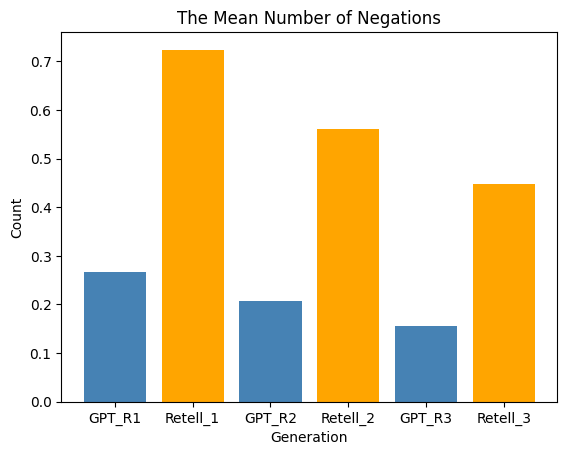

In [291]:
plt.bar(adv['gen'],adv['mean'], color=['steelblue','orange'])
plt.title('The Mean Number of Negations')
plt.xlabel('Generation')
plt.ylabel('Count')

## 1.7. Statistical Test for Negations Change Scores

Adverbs-Negations (Calculated by subtracting negation counts from original from following Retelling) between Humans & ChatGPT

### 1.7.1. First Retelling 

In [292]:
# Include stories with negations only (exclude zeros)
df_nozero = df[df.tokenized_STORY_tag_adv!= 0]

# Create change score variables by subtracting the number of negations from the number of retell-1's negations 
df1 =  (df_nozero.tokenized_Retell_1_tag_adv)-(df_nozero.tokenized_STORY_tag_adv) # Human
df2 = (df_nozero.tokenized_GPT_R1_tag_adv)-(df_nozero.tokenized_STORY_tag_adv)    # ChatGPT

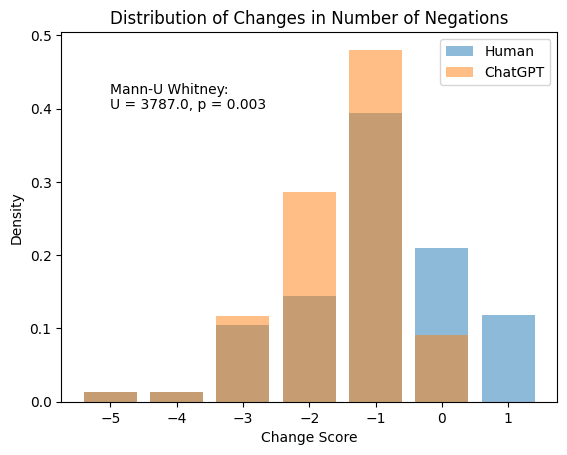

In [293]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

mybins =np.arange(-5,3,1)-0.5
ticks = np.arange(-5,3,1)
fig, ax = plt.subplots()

# Plot the first histogram
ax.hist(df1, bins=mybins, rwidth=0.8, alpha = 0.5, density=True, label='Human')
ax.set_xticks(ticks)

# Plot the second histogram on the same axes
ax.hist(df2, bins=mybins, rwidth=0.8, density=True, alpha = 0.5, label='ChatGPT')

# Remove the minor ticks and their labels
ax.xaxis.set_minor_locator(tkr.NullLocator())

# Add labels, title, and legend
ax.set_xlabel('Change Score')
ax.set_ylabel('Density')
ax.set_title('Distribution of Changes in Number of Negations')
ax.legend()


U1, p = mannwhitneyu(df1, df2, method="exact")
p = round(p,3)
plt.text(-5, 0.4, f'U = {U1}, p = {p}')
plt.text(-5, 0.42, 'Mann-U Whitney:')

plt.show()

In [294]:
# Test for normality
# Shapiro-Wilk Test

shapiro(df2)
shapiro(df1)

ShapiroResult(statistic=0.9337356090545654, pvalue=0.0005905413418076932)

In [295]:
# Test for these non-parametric test

from scipy.stats import mannwhitneyu
U1, p = mannwhitneyu(df1, df2, method="exact")
print(f'stat = {U1}, p value = {p}')
df1_m = df1.mean()
df2_m = df2.mean()
print(f'human mean= {df1_m}, ChatGPT mean= {df2_m}')

stat = 3787.0, p value = 0.0028099408389404335
human mean= -0.961038961038961, ChatGPT mean= -1.5194805194805194


### 1.7.2. Comparison of Negations in Happy and Sad Memories

#### Assign Emotion Variable

In [296]:
# Assign Emotion 

numbers= list(range(0,116)) # all list

# Assign 'happy' to the first 20 rows and 'sad' to the rest
df['emotion'] = ['happy' if (num < 47) or (97 <= num < 108) else 'sad' for num in numbers]

### 1.  First Retelling - Original 

In [297]:
#Include stories with negations only (exclude zeros)
df_nozero = df[df.tokenized_STORY_tag_adv!= 0]


df_nozero['first_human_change'] = (df_nozero.tokenized_Retell_1_tag_adv)-(df_nozero.tokenized_STORY_tag_adv) 
df_nozero['first_gpt_change'] = (df_nozero.tokenized_GPT_R1_tag_adv)-(df_nozero.tokenized_STORY_tag_adv)    # ChatGPT

df_nozero['first_human_change_ratio'] = ((df_nozero.tokenized_Retell_1_tag_adv)-(df_nozero.tokenized_STORY_tag_adv))/ df_nozero.tokenized_STORY_tag_adv
df_nozero['first_gpt_change_ratio'] = ((df_nozero.tokenized_GPT_R1_tag_adv)-(df_nozero.tokenized_STORY_tag_adv)) /df_nozero.tokenized_STORY_tag_adv   # ChatGPT

#Look the counts of change scores

#       HAPPY 
df_nozero[df_nozero['emotion']=='happy']['first_human_change'].value_counts() # One increase (N=1)
df_nozero[df_nozero['emotion']=='happy']['first_gpt_change'].value_counts() # No increase

#      SAD
df_nozero[df_nozero['emotion']=='sad']['first_human_change'].value_counts() # Nine increase (N=9)
df_nozero[df_nozero['emotion']=='sad']['first_gpt_change'].value_counts() # No increase



#   SIGNIFICANCE TEST 

# Happy (Human vs. GPT ) ---- different
U1, p1 = mannwhitneyu(df_nozero[df_nozero['emotion']=='happy']['first_human_change'],df_nozero[df_nozero['emotion']=='happy']['first_gpt_change'], method="exact")
p1



# Sad (Human vs. GPT) ----- different

U2, p2 = mannwhitneyu(df_nozero[df_nozero['emotion']=='sad']['first_human_change'], df_nozero[df_nozero['emotion']=='sad']['first_gpt_change'], method="exact")
p2


human_mean_h = (df_nozero[df_nozero['emotion']=='happy']['first_human_change']).mean()
gpt_mean_h = (df_nozero[df_nozero['emotion']=='happy']['first_gpt_change']).mean()

human_mean_s = (df_nozero[df_nozero['emotion']=='sad']['first_human_change']).mean()
gpt_mean_s = (df_nozero[df_nozero['emotion']=='sad']['first_gpt_change']).mean()

print(f'In first retelling: \n Human Happy Mean = {human_mean_h}, GPT Happy Mean = {gpt_mean_h}, p value = {p1},\n  Human Sad Mean = {human_mean_s}, GPT Sad Mean = {gpt_mean_s}, p value = {p2}')


In first retelling: 
 Human Happy Mean = -1.0, GPT Happy Mean = -1.4545454545454546, p value = 0.05907145919014812,
  Human Sad Mean = -0.9318181818181818, GPT Sad Mean = -1.5681818181818181, p value = 0.02737501171267082


/var/folders/l4/1xnf5c593754ph42_t0k68480000gq/T/ipykernel_12283/3778787132.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nozero['first_human_change'] = (df_nozero.tokenized_Retell_1_tag_adv)-(df_nozero.tokenized_STORY_tag_adv)
/var/folders/l4/1xnf5c593754ph42_t0k68480000gq/T/ipykernel_12283/3778787132.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nozero['first_gpt_change'] = (df_nozero.tokenized_GPT_R1_tag_adv)-(df_nozero.tokenized_STORY_tag_adv)    # ChatGPT
/var/folders/l4/1xnf5c593754p

#### 1. Comparison of Within Groups (First Retelling)

### 1. Mann u Whitney

In [298]:
#   SIGNIFICANCE TEST 

# Human (happy vs. sad) ---- no difference
U1, p1 = mannwhitneyu(df_nozero[df_nozero['emotion']=='happy']['first_human_change'],df_nozero[df_nozero['emotion']=='sad']['first_human_change'], method="exact")
p1



# GPT (happy vs. sad) ----- no difference

U2, p2 = mannwhitneyu(df_nozero[df_nozero['emotion']=='happy']['first_gpt_change'], df_nozero[df_nozero['emotion']=='happy']['first_human_change'], method="exact")
U2, p2


human_mean_h = (df_nozero[df_nozero['emotion']=='happy']['first_human_change']).mean()
gpt_mean_h = (df_nozero[df_nozero['emotion']=='happy']['first_gpt_change']).mean()

human_mean_s = (df_nozero[df_nozero['emotion']=='sad']['first_human_change']).mean()
gpt_mean_s = (df_nozero[df_nozero['emotion']=='sad']['first_gpt_change']).mean()

print(f'First retelling: \n Human Happy Mean = {human_mean_h}, Human Sad Mean = {human_mean_s}, p value = {p1},\n GPT Happy Mean = {gpt_mean_h}, GPT Sad Mean = {gpt_mean_s}, p value = {p2}, U = {U2}')


# Overall

human_mean = (df_nozero['first_human_change']).mean()
gpt_mean = (df_nozero['first_gpt_change']).mean()

U2, p2 = mannwhitneyu(df_nozero['first_human_change'], df_nozero['first_gpt_change'], method="exact")
#U2, p2, human_mean, gpt_mean


First retelling: 
 Human Happy Mean = -1.0, Human Sad Mean = -0.9318181818181818, p value = 0.938834437991539,
 GPT Happy Mean = -1.4545454545454546, GPT Sad Mean = -1.5681818181818181, p value = 0.05907145919014812, U = 397.0


### 1. Overall t-test  (Ratio-Original)

In [299]:
# Look at variance in gpt and human in third

#Means
mean_human = round(np.mean(df_nozero['first_human_change_ratio']),3)
mean_gpt = round(np.mean(df_nozero['first_gpt_change_ratio']),3)

#Variances
sd_human = round(np.var(df_nozero['first_human_change']),3)
sd_gpt = round(np.var(df_nozero['first_gpt_change_ratio']),3)


#Welsch's t test
test = (stats.ttest_ind(df_nozero['first_gpt_change_ratio'], df_nozero['first_human_change_ratio'], equal_var = False))

# Get degrees of freedom
def welch_dof(x,y):
        dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
        return(f"{dof:.1f}")

def degrees_of_freedom(x,y):
    dof = (len(x) - 1) + (len(y) - 1)
    return dof

        
dfs = welch_dof(df_nozero['first_gpt_change_ratio'], df_nozero['first_human_change_ratio'])


dfreedom= degrees_of_freedom(df_nozero['first_gpt_change_ratio'], df_nozero['first_human_change_ratio'])

print(f'First Retelling (t-test) :\nThe difference between human (M = {mean_human}, SD = {sd_human}) and \nChatGPT (M = {mean_gpt}, SD = {sd_gpt}) is significant (t({dfreedom}) = {round(test[0],3)}, p = {round(test[1],4)})')


First Retelling (t-test) :
The difference between human (M = -0.398, SD = 1.674) and 
ChatGPT (M = -0.815, SD = 0.1) is significant (t(152) = -4.896, p = 0.0)


### 1.Overall t-test  (Ratio-Original -Sad)

In [300]:
# Look at variance in gpt and human 

#Means
mean_human = round(np.mean(df_nozero[df_nozero['emotion']=='sad']['first_human_change_ratio']),3)
mean_gpt = round(np.mean(df_nozero[df_nozero['emotion']=='sad']['first_gpt_change_ratio']),3)

#Variances
sd_human = round(np.var(df_nozero[df_nozero['emotion']=='sad']['first_human_change_ratio']),4)
sd_gpt = round(np.var(df_nozero[df_nozero['emotion']=='sad']['first_gpt_change_ratio']),4)


#Welsch's t test
test = (stats.ttest_ind(df_nozero[df_nozero['emotion']=='sad']['first_gpt_change_ratio'], df_nozero[df_nozero['emotion']=='sad']['first_human_change_ratio'], equal_var = False))

# Get degrees of freedom
def welch_dof(x,y):
        dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
        return(f"{dof:.1f}")
        
dfs = welch_dof(df_nozero[df_nozero['emotion']=='sad']['first_gpt_change_ratio'], df_nozero[df_nozero['emotion']=='sad']['first_human_change_ratio'])




print(f' In first retelling (Sad Stories): \n The difference between human (M = {mean_human}, SD = {sd_human})  \n ChatGPT (M = {mean_gpt}, SD = {sd_gpt}) is significant (t({dfreedom}) = {round(test[0],3)}, p = {round(test[1],3)})')
      

 In first retelling (Sad Stories): 
 The difference between human (M = -0.341, SD = 0.5997)  
 ChatGPT (M = -0.828, SD = 0.0778) is significant (t(152) = -3.878, p = 0.0)


### 1.Overall t-test  (Ratio-Original-Happy)

In [301]:
# Look at variance in gpt and human 

#Means
mean_human = round(np.mean(df_nozero[df_nozero['emotion']=='happy']['first_human_change_ratio']),3)
mean_gpt = round(np.mean(df_nozero[df_nozero['emotion']=='happy']['first_gpt_change_ratio']),3)

#Variances
sd_human = round(np.var(df_nozero[df_nozero['emotion']=='happy']['first_human_change_ratio']),4)
sd_gpt = round(np.var(df_nozero[df_nozero['emotion']=='happy']['first_gpt_change_ratio']),4)


#Welsch's t test
test = (stats.ttest_ind(df_nozero[df_nozero['emotion']=='happy']['first_gpt_change_ratio'], df_nozero[df_nozero['emotion']=='happy']['first_human_change_ratio'], equal_var = False))

# Get degrees of freedom
def welch_dof(x,y):
        dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
        return(f"{dof:.1f}")
        
dfs = welch_dof(df_nozero[df_nozero['emotion']=='happy']['first_gpt_change_ratio'], df_nozero[df_nozero['emotion']=='happy']['first_human_change_ratio'])




print(f' In first retelling (Happy Stories): \n The difference between human (M = {mean_human}, SD = {sd_human})  \n ChatGPT (M = {mean_gpt}, SD = {sd_gpt}) is significant (t({dfreedom}) = {round(test[0],2)}, p = {round(test[1],2)})')
      

 In first retelling (Happy Stories): 
 The difference between human (M = -0.475, SD = 0.2409)  
 ChatGPT (M = -0.798, SD = 0.1292) is significant (t(152) = -3.01, p = 0.0)


### 1.T-Test - First Retelling (Sad Stories) - Raw Scores

In [302]:
# Look at variance in gpt and human 

#Means
mean_human = round(np.mean(df_nozero[df_nozero['emotion']=='sad']['first_human_change']),2)
mean_gpt = round(np.mean(df_nozero[df_nozero['emotion']=='sad']['first_gpt_change']),2)

#Variances
sd_human = round(np.var(df_nozero[df_nozero['emotion']=='sad']['first_human_change']),2)
sd_gpt = round(np.var(df_nozero[df_nozero['emotion']=='sad']['first_gpt_change']),2)


#Welsch's t test
test = (stats.ttest_ind(df_nozero[df_nozero['emotion']=='sad']['first_gpt_change'], df_nozero[df_nozero['emotion']=='sad']['first_human_change'], equal_var = False))

# Get degrees of freedom
def welch_dof(x,y):
        dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
        return(f"{dof:.1f}")
        
dfs = welch_dof(df_nozero[df_nozero['emotion']=='sad']['first_gpt_change'], df_nozero[df_nozero['emotion']=='sad']['first_human_change'])




print(f' In first retelling (Sad Stories): \n The difference between human (M = {mean_human}, SD = {sd_human})  \n ChatGPT (M = {mean_gpt}, SD = {sd_gpt}) is significant (t({dfs}) = {round(test[0],2)}, p = {round(test[1],2)})')
      

 In first retelling (Sad Stories): 
 The difference between human (M = -0.93, SD = 1.93)  
 ChatGPT (M = -1.57, SD = 0.75) is significant (t(71.9) = -2.55, p = 0.01)


### 1.T-Test - First Retelling (Happy Stories) - Raw Scores

In [303]:
# Look at variance in gpt and human 

#Means
mean_human = round(np.mean(df_nozero[df_nozero['emotion']=='happy']['first_human_change']),2)
mean_gpt = round(np.mean(df_nozero[df_nozero['emotion']=='happy']['first_gpt_change']),2)

#Variances
sd_human = round(np.var(df_nozero[df_nozero['emotion']=='happy']['first_human_change']),2)
sd_gpt = round(np.var(df_nozero[df_nozero['emotion']=='happy']['first_gpt_change']),2)


#Welsch's t test
test = (stats.ttest_ind(df_nozero[df_nozero['emotion']=='happy']['first_gpt_change'], df_nozero[df_nozero['emotion']=='happy']['first_human_change'], equal_var = False))

# Get degrees of freedom
def welch_dof(x,y):
        dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
        return(f"{dof:.1f}")
        
dfs = welch_dof(df_nozero[df_nozero['emotion']=='happy']['first_gpt_change'], df_nozero[df_nozero['emotion']=='happy']['first_human_change'])




print(f' In first retelling (Happy Stories): \n The difference between human (M = {mean_human}, SD = {sd_human})  \n ChatGPT (M = {mean_gpt}, SD = {sd_gpt}) is significant (t({dfreedom}) = {round(test[0],2)}, p = {round(test[1],2)})')
      

 In first retelling (Happy Stories): 
 The difference between human (M = -1.0, SD = 1.33)  
 ChatGPT (M = -1.45, SD = 1.1) is significant (t(152) = -1.65, p = 0.1)


### 2. Second Retelling - First Retelling


In [304]:
#Include stories with negations only (exclude zeros)
df_nozero_h = df[(df.tokenized_Retell_1_tag_adv!= 0)]
df_nozero_g =  df[(df.tokenized_GPT_R1_tag_adv!= 0)]

df_nozero_h['second_human_change'] = (df_nozero_h.tokenized_Retell_2_tag_adv)-(df_nozero_h.tokenized_Retell_1_tag_adv) 
df_nozero_g['second_gpt_change'] = (df_nozero_g.tokenized_GPT_R2_tag_adv)-(df_nozero_g.tokenized_GPT_R1_tag_adv)    # ChatGPT

df_nozero_h['second_human_change_ratio'] = ((df_nozero_h.tokenized_Retell_2_tag_adv)-(df_nozero_h.tokenized_Retell_1_tag_adv))/ (df_nozero_h.tokenized_Retell_1_tag_adv)
df_nozero_g['second_gpt_change_ratio'] = ((df_nozero_g.tokenized_GPT_R2_tag_adv)-(df_nozero_g.tokenized_GPT_R1_tag_adv))/(df_nozero_g.tokenized_GPT_R1_tag_adv)    # ChatGPT


/var/folders/l4/1xnf5c593754ph42_t0k68480000gq/T/ipykernel_12283/847835382.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nozero_h['second_human_change'] = (df_nozero_h.tokenized_Retell_2_tag_adv)-(df_nozero_h.tokenized_Retell_1_tag_adv)
/var/folders/l4/1xnf5c593754ph42_t0k68480000gq/T/ipykernel_12283/847835382.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nozero_g['second_gpt_change'] = (df_nozero_g.tokenized_GPT_R2_tag_adv)-(df_nozero_g.tokenized_GPT_R1_tag_adv)    # ChatGPT
/var/folders/

### 2. Overall Mann-U Whitney 

In [305]:
human_mean = (df_nozero_h['second_human_change']).mean()
gpt_mean = (df_nozero_g['second_gpt_change']).mean()

U2, p2 = mannwhitneyu(df_nozero_h['second_human_change'], df_nozero_g['second_gpt_change'], method="exact")
U2, p2, human_mean, gpt_mean

(716.5, 0.3983738613677733, -0.6166666666666667, -0.4444444444444444)

### 2. Overall t-test  (Ratio-Original)

In [306]:
# Look at variance in gpt and human in third

#Means
mean_human = round(np.mean(df_nozero_h['second_human_change_ratio']),3)
mean_gpt = round(np.mean(df_nozero_g['second_gpt_change_ratio']),3)

#Variances
sd_human = round(np.var(df_nozero_h['second_human_change_ratio']),4)
sd_gpt = round(np.var(df_nozero_g['second_gpt_change_ratio']),4)


#Welsch's t test
test = (stats.ttest_ind(df_nozero_g['second_gpt_change_ratio'], df_nozero_h['second_human_change_ratio'], equal_var = False))


dfs = welch_dof(df_nozero_g['second_gpt_change_ratio'], df_nozero_h['second_human_change_ratio'])




print(f'Second Retelling (All Stories):\nThe difference between human (M = {mean_human}, SD = {sd_human}) and \nChatGPT (M = {mean_gpt}, SD = {sd_gpt}) is not significant (t({dfreedom}) = {round(test[0],3)}, p = {round(test[1],3)})')
      

Second Retelling (All Stories):
The difference between human (M = -0.425, SD = 0.3365) and 
ChatGPT (M = -0.37, SD = 0.2888) is not significant (t(152) = 0.421, p = 0.675)


### 2. Overall t-test  (Ratio-Original-Sad)

In [307]:
# Look at variance in gpt and human in third

#Means
mean_human = round(np.mean(df_nozero_h[df_nozero_h['emotion']=='sad']['second_human_change_ratio']),2)
mean_gpt = round(np.mean(df_nozero_g[df_nozero_g['emotion']=='sad']['second_gpt_change_ratio']),2)

#Variances
sd_human = round(np.var(df_nozero_h[df_nozero_h['emotion']=='sad']['second_human_change_ratio']),2)
sd_gpt = round(np.var(df_nozero_g[df_nozero_g['emotion']=='sad']['second_gpt_change_ratio']),2)


#Welsch's t test
test = (stats.ttest_ind(df_nozero_g[df_nozero_g['emotion']=='sad']['second_gpt_change_ratio'], df_nozero_h[df_nozero_h['emotion']=='sad']['second_human_change_ratio'], equal_var = False))

# Get degrees of freedom
def welch_dof(x,y):
        dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
        return(f"{dof:.1f}")
        
dfs = welch_dof(df_nozero_g[df_nozero_g['emotion']=='sad']['second_gpt_change_ratio'], df_nozero_h[df_nozero_h['emotion']=='sad']['second_human_change_ratio'])




print(f'Second Retelling (Sad Stories):\nThe difference between human (M = {mean_human}, SD = {sd_human}) and \nChatGPT (M = {mean_gpt}, SD = {sd_gpt}) is not significant (t({dfs}) = {round(test[0],2)}, p = {round(test[1],2)})')
      

Second Retelling (Sad Stories):
The difference between human (M = -0.39, SD = 0.29) and 
ChatGPT (M = -0.2, SD = 0.26) is not significant (t(28.9) = 1.11, p = 0.28)


### 2. Overall t-test  (Ratio-Original-Happy)

In [308]:
# Look at variance in gpt and human in third

#Means
mean_human = round(np.mean(df_nozero_h[df_nozero_h['emotion']=='happy']['second_human_change_ratio']),2)
mean_gpt = round(np.mean(df_nozero_g[df_nozero_g['emotion']=='happy']['second_gpt_change_ratio']),2)

#Variances
sd_human = round(np.var(df_nozero_h[df_nozero_h['emotion']=='happy']['second_human_change_ratio']),2)
sd_gpt = round(np.var(df_nozero_g[df_nozero_g['emotion']=='happy']['second_gpt_change_ratio']),2)


#Welsch's t test
test = (stats.ttest_ind(df_nozero_g[df_nozero_g['emotion']=='happy']['second_gpt_change_ratio'], df_nozero_h[df_nozero_h['emotion']=='happy']['second_human_change_ratio'], equal_var = False))

# Get degrees of freedom
def welch_dof(x,y):
        dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
        return(f"{dof:.1f}")
        
dfs = welch_dof(df_nozero_g[df_nozero_g['emotion']=='happy']['second_gpt_change_ratio'], df_nozero_h[df_nozero_h['emotion']=='happy']['second_human_change_ratio'])
print(f'Second Retelling (Happy Stories):\nThe difference between human (M = {mean_human}, SD = {sd_human}) and \nChatGPT (M = {mean_gpt}, SD = {sd_gpt}) is not significant (t({dfs}) = {round(test[0],2)}, p = {round(test[1],2)})')


Second Retelling (Happy Stories):
The difference between human (M = -0.47, SD = 0.38) and 
ChatGPT (M = -0.58, SD = 0.24) is not significant (t(24.9) = -0.62, p = 0.54)


#### Comparison of Within Groups (Second Retelling)

In [309]:
#   SIGNIFICANCE TEST 

# Human (happy vs. sad) ---- no difference
U1, p1 = mannwhitneyu(df_nozero_h[df_nozero_h['emotion']=='happy']['second_human_change'],df_nozero_h[df_nozero_h['emotion']=='sad']['second_human_change'], method="exact")
p1



# GPT (happy vs. sad) ----- no difference

U2, p2 = mannwhitneyu(df_nozero_g[df_nozero_g['emotion']=='happy']['second_gpt_change'], df_nozero_g[df_nozero_g['emotion']=='sad']['second_gpt_change'], method="exact")
p2


human_mean_h = (df_nozero_h[df_nozero_h['emotion']=='happy']['second_human_change']).mean()
gpt_mean_h = (df_nozero_g[df_nozero_g['emotion']=='happy']['second_gpt_change']).mean()

human_mean_s = (df_nozero_h[df_nozero_h['emotion']=='sad']['second_human_change']).mean()
gpt_mean_s = (df_nozero_g[df_nozero_g['emotion']=='sad']['second_gpt_change']).mean()

print(f'Human Happy Mean = {human_mean_h}, Human Sad Mean = {human_mean_s}, p value = {p1},\n GPT Happy Mean = {gpt_mean_h}, GPT Sad Mean = {gpt_mean_s}, p value = {p2}')


Human Happy Mean = -0.5862068965517241, Human Sad Mean = -0.6451612903225806, p value = 0.906504105847598,
 GPT Happy Mean = -0.5833333333333334, GPT Sad Mean = -0.3333333333333333, p value = 0.32285706396623076


### 2. T-Test - Second Retelling (Sad - Raw Scores)

In [310]:
# Look at variance in gpt and human 

#Means
mean_human = round(np.mean(df_nozero_h[df_nozero_h['emotion']=='sad']['second_human_change']),2)
mean_gpt = round(np.mean(df_nozero_g[df_nozero_g['emotion']=='sad']['second_gpt_change']),2)

#Variances
sd_human = round(np.var(df_nozero_h[df_nozero_h['emotion']=='sad']['second_human_change']),2)
sd_gpt = round(np.var(df_nozero_g[df_nozero_g['emotion']=='sad']['second_gpt_change']),2)


#Welsch's t test
test = (stats.ttest_ind(df_nozero_g[df_nozero_g['emotion']=='sad']['second_gpt_change'], df_nozero_h[df_nozero_h['emotion']=='sad']['second_human_change'], equal_var = False))

# Get degrees of freedom
def welch_dof(x,y):
        dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
        return(f"{dof:.1f}")
        
dfs = welch_dof(df_nozero_g[df_nozero_g['emotion']=='sad']['second_gpt_change'], df_nozero_h[df_nozero_h['emotion']=='sad']['second_human_change'])




print(f'Second retelling (Sad Stories): \nThe difference between human (M = {mean_human}, SD = {sd_human}) and \nChatGPT (M = {mean_gpt}, SD = {sd_gpt}) is significant (t({dfs}) = {round(test[0],2)}, p = {round(test[1],2)})')
      

Second retelling (Sad Stories): 
The difference between human (M = -0.65, SD = 0.87) and 
ChatGPT (M = -0.33, SD = 0.49) is significant (t(35.6) = 1.23, p = 0.23)


### 2. T-Test - Second Retelling (Happy - Raw Scores)

In [311]:
# Look at variance in gpt and human 

#Means
mean_human = round(np.mean(df_nozero_h[df_nozero_h['emotion']=='happy']['second_human_change']),2)
mean_gpt = round(np.mean(df_nozero_g[df_nozero_g['emotion']=='happy']['second_gpt_change']),2)

#Variances
sd_human = round(np.var(df_nozero_h[df_nozero_h['emotion']=='happy']['second_human_change']),2)
sd_gpt = round(np.var(df_nozero_g[df_nozero_g['emotion']=='happy']['second_gpt_change']),2)


#Welsch's t test
test = (stats.ttest_ind(df_nozero_g[df_nozero_g['emotion']=='happy']['second_gpt_change'], df_nozero_h[df_nozero_h['emotion']=='happy']['second_human_change'], equal_var = False))

# Get degrees of freedom
def welch_dof(x,y):
        dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
        return(f"{dof:.1f}")
        
dfs = welch_dof(df_nozero_g[df_nozero_g['emotion']=='happy']['second_gpt_change'], df_nozero_h[df_nozero_h['emotion']=='happy']['second_human_change'])




print(f'Second retelling (Happy Stories): \nThe difference between human (M = {mean_human}, SD = {sd_human}) and \nChatGPT (M = {mean_gpt}, SD = {sd_gpt}) is significant (t({dfs}) = {round(test[0],2)}, p = {round(test[1],2)})')
      

Second retelling (Happy Stories): 
The difference between human (M = -0.59, SD = 0.59) and 
ChatGPT (M = -0.58, SD = 0.24) is significant (t(30.9) = 0.01, p = 0.99)


### 3. Third Retelling - Second Retelling


In [312]:
#Include stories with negations only (exclude zeros)
df_nozero_h = df[(df.tokenized_Retell_2_tag_adv!= 0)]
df_nozero_g = df[(df.tokenized_GPT_R2_tag_adv!= 0)]

df_nozero_h['third_human_change'] = (df_nozero_h.tokenized_Retell_3_tag_adv)-(df_nozero_h.tokenized_Retell_2_tag_adv)
df_nozero_g['third_gpt_change'] = (df_nozero_g.tokenized_GPT_R3_tag_adv)-(df_nozero_g.tokenized_GPT_R2_tag_adv)   # ChatGPT

df_nozero_h['third_human_change_ratio'] = ((df_nozero_h.tokenized_Retell_3_tag_adv)-(df_nozero_h.tokenized_Retell_2_tag_adv))/df_nozero_h.tokenized_Retell_2_tag_adv
df_nozero_g['third_gpt_change_ratio'] = ((df_nozero_g.tokenized_GPT_R3_tag_adv)-(df_nozero_g.tokenized_GPT_R2_tag_adv))/ df_nozero_g.tokenized_GPT_R2_tag_adv  # ChatGPT


/var/folders/l4/1xnf5c593754ph42_t0k68480000gq/T/ipykernel_12283/995283378.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nozero_h['third_human_change'] = (df_nozero_h.tokenized_Retell_3_tag_adv)-(df_nozero_h.tokenized_Retell_2_tag_adv)
/var/folders/l4/1xnf5c593754ph42_t0k68480000gq/T/ipykernel_12283/995283378.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nozero_g['third_gpt_change'] = (df_nozero_g.tokenized_GPT_R3_tag_adv)-(df_nozero_g.tokenized_GPT_R2_tag_adv)   # ChatGPT
/var/folders/l4/

### 3. Overall Mann U Whitney

In [313]:
human_mean = (df_nozero_h['third_human_change']).mean()
gpt_mean = (df_nozero_g['third_gpt_change']).mean()

U2, p2 = mannwhitneyu(df_nozero_h['third_human_change'], df_nozero_g['third_gpt_change'], method="exact")
U2, p2, human_mean, gpt_mean

(463.5, 0.5019348777722328, -0.574468085106383, -0.36363636363636365)

#### Comparison of Within Groups (Third Retelling)

In [314]:
#   SIGNIFICANCE TEST 

# Human (happy vs. sad) ---- no difference
U1, p1 = mannwhitneyu(df_nozero_h[df_nozero_h['emotion']=='happy']['third_human_change'],df_nozero_h[df_nozero_h['emotion']=='sad']['third_human_change'], method="exact")
p1



# GPT (happy vs. sad) ----- no difference

U2, p2 = mannwhitneyu(df_nozero_g[df_nozero_g['emotion']=='happy']['third_gpt_change'], df_nozero_g[df_nozero_g['emotion']=='sad']['third_gpt_change'], method="exact")
p2


human_mean_h = (df_nozero_h[df_nozero_h['emotion']=='happy']['third_human_change']).mean()
gpt_mean_h = (df_nozero_g[df_nozero_g['emotion']=='happy']['third_gpt_change']).mean()

human_mean_s = (df_nozero_h[df_nozero_h['emotion']=='sad']['third_human_change']).mean()
gpt_mean_s = (df_nozero_g[df_nozero_g['emotion']=='sad']['third_gpt_change']).mean()

print(f'Third Retelling: \nHuman Happy Mean = {human_mean_h}, Human Sad Mean = {human_mean_s}, p value = {p1},\nGPT Happy Mean = {gpt_mean_h}, GPT Sad Mean = {gpt_mean_s}, p value = {p2}')


Third Retelling: 
Human Happy Mean = -0.3333333333333333, Human Sad Mean = -0.7692307692307693, p value = 0.1828732709264269,
GPT Happy Mean = -0.14285714285714285, GPT Sad Mean = -0.4666666666666667, p value = 0.44747396566282005


### 3. Overal T-test Ratio (Third-All)

In [315]:
# Look at variance in gpt and human in third

#Means
mean_human = round(np.mean(df_nozero_h['third_human_change_ratio']),3)
mean_gpt = round(np.mean(df_nozero_g['third_gpt_change_ratio']),3)

#Variances
sd_human = round(np.var(df_nozero_h['third_human_change']),4)
sd_gpt = round(np.var(df_nozero_g['third_gpt_change_ratio']),4)


#Welsch's t test
test = (stats.ttest_ind(df_nozero_g['third_gpt_change_ratio'], df_nozero_h['third_human_change_ratio'], equal_var = False))


        
dfs = welch_dof(df_nozero_g['third_gpt_change_ratio'], df_nozero_h['third_human_change_ratio'])




print(f'Third Retelling :\nThe difference between human (M = {mean_human}, SD = {sd_human}) and \nChatGPT (M = {mean_gpt}, SD = {sd_gpt}) is not significant (t({dfreedom}) = {round(test[0],3)}, p = {round(test[1],3)})')


Third Retelling :
The difference between human (M = -0.371, SD = 0.8402) and 
ChatGPT (M = -0.318, SD = 0.3079) is not significant (t(152) = 0.362, p = 0.719)


### 3. T-Test (Third Retelling - Sad - Raw Score)

In [316]:
# Look at variance in gpt and human in third

#Means
mean_human = round(np.mean(df_nozero_h[df_nozero_h['emotion']=='sad']['third_human_change']),2)
mean_gpt = round(np.mean(df_nozero_g[df_nozero_g['emotion']=='sad']['third_gpt_change']),2)

#Variances
sd_human = round(np.var(df_nozero_h[df_nozero_h['emotion']=='sad']['third_human_change']),2)
sd_gpt = round(np.var(df_nozero_g[df_nozero_g['emotion']=='sad']['third_gpt_change']),2)


#Welsch's t test
test = (stats.ttest_ind(df_nozero_g[df_nozero_g['emotion']=='sad']['third_gpt_change'], df_nozero_h[df_nozero_h['emotion']=='sad']['third_human_change'], equal_var = False))

# Get degrees of freedom
def welch_dof(x,y):
        dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
        return(f"{dof:.1f}")
        
dfs = welch_dof(df_nozero_g[df_nozero_g['emotion']=='sad']['third_gpt_change'], df_nozero_h[df_nozero_h['emotion']=='sad']['third_human_change'])




print(f'Third Retelling (Sad Stories):\nThe difference between human (M = {mean_human}, SD = {sd_human}) and \nChatGPT (M = {mean_gpt}, SD = {sd_gpt}) is not significant (t({dfs}) = {round(test[0],2)}, p = {round(test[1],2)})')
      

Third Retelling (Sad Stories):
The difference between human (M = -0.77, SD = 1.1) and 
ChatGPT (M = -0.47, SD = 0.38) is not significant (t(38.9) = 1.13, p = 0.26)


### 3. T-Test (Third Retelling - Happy - Raw Scores)

In [317]:
# Look at variance in gpt and human in third

#Means
mean_human = round(np.mean(df_nozero_h[df_nozero_h['emotion']=='happy']['third_human_change']),2)
mean_gpt = round(np.mean(df_nozero_g[df_nozero_g['emotion']=='happy']['third_gpt_change']),2)

#Variances
sd_human = round(np.var(df_nozero_h[df_nozero_h['emotion']=='happy']['third_human_change']),2)
sd_gpt = round(np.var(df_nozero_g[df_nozero_g['emotion']=='happy']['third_gpt_change']),2)


#Welsch's t test
test = (stats.ttest_ind(df_nozero_g[df_nozero_g['emotion']=='happy']['third_gpt_change'], df_nozero_h[df_nozero_h['emotion']=='happy']['third_human_change'], equal_var = False))


        
dfs = welch_dof(df_nozero_g[df_nozero_g['emotion']=='happy']['third_gpt_change'], df_nozero_h[df_nozero_h['emotion']=='happy']['third_human_change'])




print(f'Third Retelling (Happy Stories):\nThe difference between human (M = {mean_human}, SD = {sd_human}) and \nChatGPT (M = {mean_gpt}, SD = {sd_gpt}) is not significant (t({dfs}) = {round(test[0],2)}, p = {round(test[1],2)})')
      

Third Retelling (Happy Stories):
The difference between human (M = -0.33, SD = 0.41) and 
ChatGPT (M = -0.14, SD = 0.41) is not significant (t(9.9) = 0.64, p = 0.54)


### 3. Ratio T-test (Third-Happy)


In [318]:
# Look at variance in gpt and human in third

#Means
mean_human = round(np.mean(df_nozero_h[df_nozero_h['emotion']=='happy']['third_human_change_ratio']),2)
mean_gpt = round(np.mean(df_nozero_g[df_nozero_g['emotion']=='happy']['third_gpt_change_ratio']),2)

#Variances
sd_human = round(np.var(df_nozero_h[df_nozero_h['emotion']=='happy']['third_human_change_ratio']),2)
sd_gpt = round(np.var(df_nozero_g[df_nozero_g['emotion']=='happy']['third_gpt_change_ratio']),2)


#Welsch's t test
test = (stats.ttest_ind(df_nozero_g[df_nozero_g['emotion']=='happy']['third_gpt_change_ratio'], df_nozero_h[df_nozero_h['emotion']=='happy']['third_human_change_ratio'], equal_var = False))


dfs = welch_dof(df_nozero_g[df_nozero_g['emotion']=='happy']['third_gpt_change_ratio'], df_nozero_h[df_nozero_h['emotion']=='happy']['third_human_change_ratio'])



print(f'Third Retelling Ratio (Happy Stories):\nThe difference between human (M = {mean_human}, SD = {sd_human}) and \nChatGPT (M = {mean_gpt}, SD = {sd_gpt}) is not significant (t({dfs}) = {round(test[0],2)}, p = {round(test[1],3)})')


Third Retelling Ratio (Happy Stories):
The difference between human (M = -0.31, SD = 0.25) and 
ChatGPT (M = -0.14, SD = 0.41) is not significant (t(8.3) = 0.59, p = 0.573)


###  3. Ratio T-test (Third-Sad)


In [319]:
# Look at variance in gpt and human in third

#Means
mean_human = round(np.mean(df_nozero_h[df_nozero_h['emotion']=='sad']['third_human_change_ratio']),2)
mean_gpt = round(np.mean(df_nozero_g[df_nozero_g['emotion']=='sad']['third_gpt_change_ratio']),2)

#Variances
sd_human = round(np.var(df_nozero_h[df_nozero_h['emotion']=='sad']['third_human_change_ratio']),2)
sd_gpt = round(np.var(df_nozero_g[df_nozero_g['emotion']=='sad']['third_gpt_change_ratio']),2)


#Welsch's t test
test = (stats.ttest_ind(df_nozero_g[df_nozero_g['emotion']=='sad']['third_gpt_change_ratio'], df_nozero_h[df_nozero_h['emotion']=='sad']['third_human_change_ratio'], equal_var = False))


dfs = welch_dof(df_nozero_g[df_nozero_g['emotion']=='sad']['third_gpt_change_ratio'], df_nozero_h[df_nozero_h['emotion']=='sad']['third_human_change_ratio'])




print(f'Third Retelling Ratio (Happy Stories):\nThe difference between human (M = {mean_human}, SD = {sd_human}) and \nChatGPT (M = {mean_gpt}, SD = {sd_gpt}) is not significant (t({dfs}) = {round(test[0],2)}, p = {round(test[1],3)})')


Third Retelling Ratio (Happy Stories):
The difference between human (M = -0.42, SD = 0.31) and 
ChatGPT (M = -0.4, SD = 0.24) is not significant (t(32.3) = 0.12, p = 0.909)


###  1.7.3. Visualize the Change of Negations in Happy and Sad Stories


### First Change

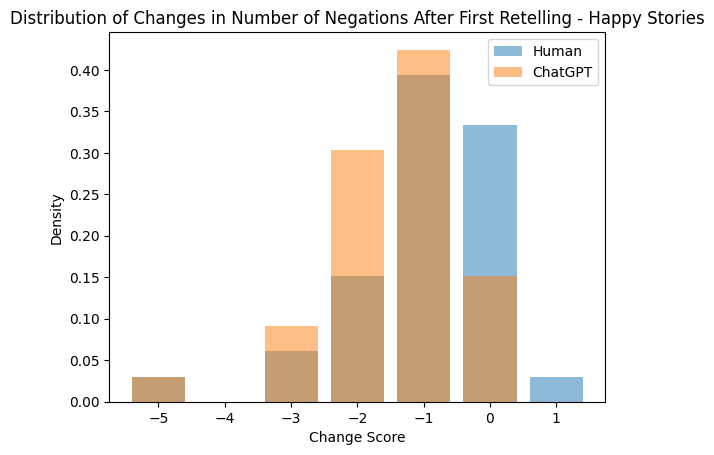

In [320]:
# Visualize: Happy

import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

mybins =np.arange(-5,3,1)-0.5
ticks = np.arange(-5,3,1)
fig, ax = plt.subplots()

# Plot the first histogram for human -first change
ax.hist([*df_nozero[df_nozero['emotion']=='happy']['first_human_change']], bins=mybins, rwidth=0.8, alpha = 0.5, density=True, label='Human')
ax.set_xticks(ticks)

# Plot the second histogram for ChatGPT - first change
ax.hist([*df_nozero[df_nozero['emotion']=='happy']['first_gpt_change']], bins=mybins, rwidth=0.8, density=True, alpha = 0.5, label='ChatGPT')

# Remove the minor ticks and their labels
ax.xaxis.set_minor_locator(tkr.NullLocator())

# Add labels, title, and legend
ax.set_xlabel('Change Score')
ax.set_ylabel('Density')
ax.set_title('Distribution of Changes in Number of Negations After First Retelling - Happy Stories')
ax.legend()


U1, p = mannwhitneyu(df1, df2, method="exact")
p = round(p,3)
#plt.text(-5, 0.4, f'U = {U1}, p = {p}')
#plt.text(-5, 0.42, 'Mann-U Whitney:')

plt.show()


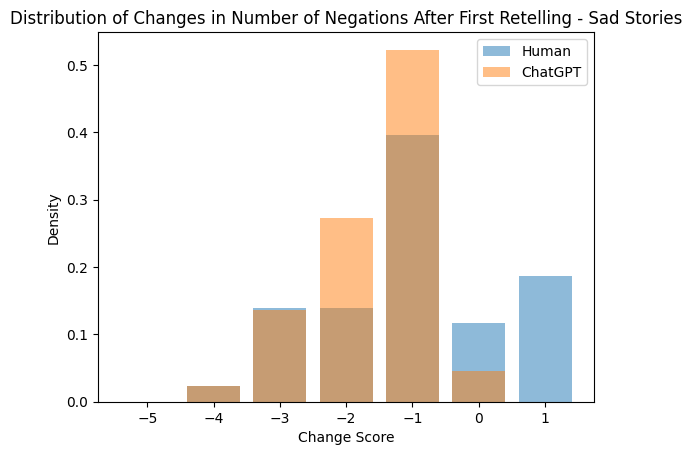

In [321]:
# Visualize: Sad

import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

mybins =np.arange(-5,3,1)-0.5
ticks = np.arange(-5,3,1)
fig, ax = plt.subplots()

# Plot the first histogram for human -first change
ax.hist([*df_nozero[df_nozero['emotion']=='sad']['first_human_change']], bins=mybins, rwidth=0.8, alpha = 0.5, density=True, label='Human')
ax.set_xticks(ticks)

# Plot the second histogram for ChatGPT - first change
ax.hist([*df_nozero[df_nozero['emotion']=='sad']['first_gpt_change']], bins=mybins, rwidth=0.8, density=True, alpha = 0.5, label='ChatGPT')

# Remove the minor ticks and their labels
ax.xaxis.set_minor_locator(tkr.NullLocator())

# Add labels, title, and legend
ax.set_xlabel('Change Score')
ax.set_ylabel('Density')
ax.set_title('Distribution of Changes in Number of Negations After First Retelling - Sad Stories')
ax.legend()


U1, p = mannwhitneyu(df1, df2, method="exact")
p = round(p,3)
#plt.text(-5, 0.4, f'U = {U1}, p = {p}')
#plt.text(-5, 0.42, 'Mann-U Whitney:')

plt.show()


In [322]:
from scipy import stats
stats.ttest_ind(df_nozero[df_nozero['emotion']=='sad']['third_human_change'],df_nozero[df_nozero['emotion']=='sad']['third_gpt_change'])



KeyError: 'third_human_change'

In [ ]:
df_nozero[df_nozero['emotion']=='happy']['third_human_change']

## 1.8. Statistical Test for Ratios

In [323]:
#!pip3 install statsmodels
#Because the values are proportions, I conducted a z-test analysis 
#Because the values are proportions, I conducted a z-test analysis 
for i in range(1, 4):
    group1 = count_ratio[f'Retell_{i}_adv_ratio']
    group2 = count_ratio[f'GPT_{i}_adv_ratio']
    statistic, pvalue = ztest(x1=group1, x2=group2, value=0)
    if pvalue < 0.05:
        print(f"Z test for GPT_R{i} ratio vs. Retell_{i} ratio is significant with p-value {pvalue}")
    else:
        print(f"Z test for GPT_R{i} ratio vs. Retell_{i} ratio is not significant with p-value {pvalue}")
        

Z test for GPT_R1 ratio vs. Retell_1 ratio is significant with p-value 0.0020834907450830754
Z test for GPT_R2 ratio vs. Retell_2 ratio is significant with p-value 0.0006181933490244548
Z test for GPT_R3 ratio vs. Retell_3 ratio is significant with p-value 0.0013395350587059724


In [324]:
# Only human

for i in range(1, 3):
    group1 = count_ratio[f'Retell_{i}_adv_ratio']
    group2 = count_ratio[f'Retell_{i+1}_adv_ratio']
    statistic, pvalue = ztest(x1=group1, x2=group2, value=0)
    if pvalue < 0.05:
        print(f"Z test for Retell_{i} ratio vs. Retell_{i+1} ratio is significant with p-value {pvalue}")
    else:
        print(f"Z test for Retell_{i} ratio vs. Retell_{i+1} ratio is not significant with p-value {pvalue}")

        
ztest(count_ratio.Retell_1_adv_ratio, count_ratio.Retell_3_adv_ratio, value=0)

Z test for Retell_1 ratio vs. Retell_2 ratio is not significant with p-value 0.6114841683472254
Z test for Retell_2 ratio vs. Retell_3 ratio is not significant with p-value 0.7531194162727526


(-0.1459568815885566, 0.8839554273235474)

In [325]:
# Only GPT

for i in range(1, 3):
    group1 = count_ratio[f'GPT_{i}_adv_ratio']
    group2 = count_ratio[f'GPT_{i+1}_adv_ratio']
    statistic, pvalue = ztest(x1=group1, x2=group2, value=0)
    if pvalue < 0.05:
        print(f"Z test for GPT_{i} ratio vs. GPT_{i+1} ratio is significant with p-value {pvalue}")
    else:
        print(f"Z test for GPT_{i} ratio vs. GPT_{i+1} ratio is not significant with p-value {pvalue}")

        
ztest(count_ratio.GPT_1_adv_ratio, count_ratio.GPT_3_adv_ratio, value=0)

Z test for GPT_1 ratio vs. GPT_2 ratio is not significant with p-value 0.6468943808774712
Z test for GPT_2 ratio vs. GPT_3 ratio is not significant with p-value 0.6732808157525589


(0.8630642885929638, 0.38810212118200726)

### 1.8.1. Visualize Ratios

In [326]:
#Because the values are proportions, I conducted a z-test analysis 

for i in range(1, 4):
    group1 = count_ratio[f'Retell_{i}_adv_ratio']
    group2 = count_ratio[f'GPT_{i}_adv_ratio']
    statistic, pvalue = ztest(x1=group1, x2=group2, value=0)
    if pvalue < 0.05:
        print(f"Z test for GPT_R{i} ratio vs. Retell_{i} ratio is significant with z = {statistic}, p-value {pvalue}")
    else:
        print(f"Z test for GPT_R{i} ratio vs. Retell_{i} ratio is not significant with z = {statistic}, p-value {pvalue}")
        
ratio_means = pd.DataFrame()
ratio_means['mean'] = [*count_ratio.mean()]
ratio_means['gen']= ['GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin']
ratio_means['type']= ['noun','noun','noun','noun','noun','noun','noun','verb','verb','verb','verb','verb','verb','verb','adj','adj','adj','adj','adj','adj','adj','adv','adv','adv','adv','adv','adv','adv','con_det_prep','con_det_prep','con_det_prep','con_det_prep','con_det_prep','con_det_prep','con_det_prep','pron','pron','pron','pron','pron','pron','pron','prep','prep','prep','prep','prep','prep','prep']
adv_ratio = ratio_means[ratio_means.type == 'adv']
adv_ratio = adv_ratio.set_index(['gen']).reindex(['GPT_1', 'Retell_1','GPT_2', 'Retell_2','GPT_3', 'Retell_3']).reset_index()


Z test for GPT_R1 ratio vs. Retell_1 ratio is significant with z = 3.078065557893003, p-value 0.0020834907450830754
Z test for GPT_R2 ratio vs. Retell_2 ratio is significant with z = 3.42350403111364, p-value 0.0006181933490244548
Z test for GPT_R3 ratio vs. Retell_3 ratio is significant with z = 3.207372323255804, p-value 0.0013395350587059724


In [327]:
adv_ratio['iteration'] = [1,1,2,2,3,3]
adv_ratio['type']=['ChatGPT','Human','ChatGPT','Human','ChatGPT','Human']
adv_ratio

grouped_data = adv_ratio.groupby(['iteration', 'type'])['mean'].mean()


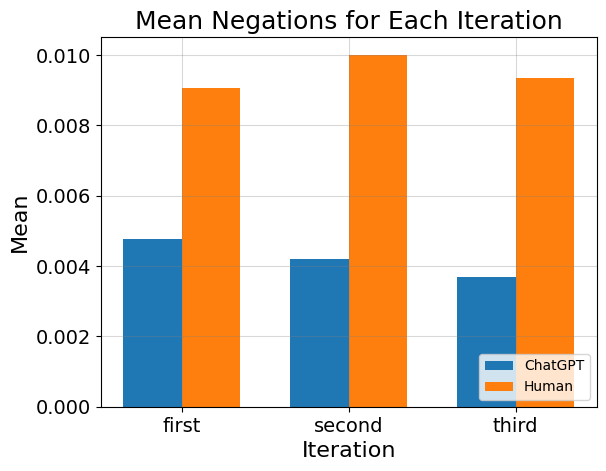

In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a DataFrame from the provided data
data = {
    'gen': ['GPT_1', 'Retell_1', 'GPT_2', 'Retell_2', 'GPT_3', 'Retell_3'],
    'mean': [0.004763, 0.009077, 0.004212, 0.010011, 0.003682, 0.009350],
    'type': ['ChatGPT', 'Human', 'ChatGPT', 'Human', 'ChatGPT', 'Human'],
    'iteration': [1, 1, 2, 2, 3, 3]
}
dm = pd.DataFrame(data)

# Group the data by iteration and type
grouped_data = dm.groupby(['iteration', 'type'])['mean'].mean().unstack()

# Get the labels for the x-axis ticks
x_labels = grouped_data.index

# Get the values for each type
chatgpt_means = grouped_data['ChatGPT']
human_means = grouped_data['Human']

# Set the width of each bar
bar_width = 0.35

# Set the positions of the bars
x = np.arange(len(x_labels))

# Create the bar graph
plt.bar(x - bar_width/2, chatgpt_means, width=bar_width, label='ChatGPT')
plt.bar(x + bar_width/2, human_means, width=bar_width, label='Human')

xlabels= ['first','second','third']
# Set the x-axis tick labels
plt.xticks(x, xlabels)

# Set the title and axis labels
plt.title('Mean Negations for Each Iteration',fontsize=18)
plt.xlabel('Iteration',fontsize=16)
plt.ylabel('Mean',fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=14)

# Set the legend
plt.legend(loc='lower right')
plt.grid(True,color='grey', alpha=0.3)
# Save it 
plt.savefig('Negations.pdf',dpi=300)
# Display the plot
plt.show()


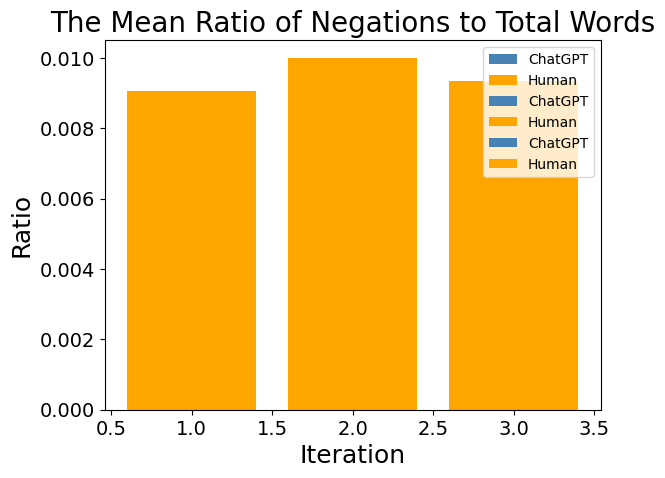

In [329]:
adv_ratio
plt.bar(adv_ratio['iteration'],adv_ratio['mean'], color=['steelblue','orange'],label=adv_ratio['type'])
plt.title('The Mean Ratio of Negations to Total Words', fontsize=20)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Ratio',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
plt.show()

## 1.9. Calculate Verb-Negation Ratio

In [330]:
#Adverb-verb ratio

#For human
for i in range(1,4):
    df[f'Retell_{i}_adv_to_verb_ratio'] = df[f'tokenized_Retell_{i}_tag_adv'] / df[f'tokenized_Retell_{i}_tag_verb']

#For GPT
for i in range(1,4):
    df[f'GPT_{i}_adv_to_verb_ratio'] = df[f'tokenized_GPT_R{i}_tag_adv'] / df[f'tokenized_GPT_R{i}_tag_verb']

# For original story
df['story_adv_to_verb_ratio'] = df['tokenized_STORY_tag_adv'] / df['tokenized_STORY_tag_verb']

In [331]:
# Adverb - Total word count ratio

retell_cols = ['Retell_1', 'Retell_2', 'Retell_3']
gpt_cols = ['GPT_R1', 'GPT_R2', 'GPT_R3']

# For human
for col in retell_cols:
    df[f'{col}_adv_to_all_words'] = df[f'tokenized_{col}_tag_adv'] / (df[f'tokenized_{col}'].apply(lambda x: len(x)))

# For GPT
for col in gpt_cols:
    df[f'{col}_adv_to_all_words'] = df[f'tokenized_{col}_tag_adv'] / (df[f'tokenized_{col}'].apply(lambda x: len(x)))

### 1.9.2. Visualize Negation/Verb

#### 1.9.2.1. Prepare dataset to visualize

In [332]:
verbnoun_ratio = df[['story_adv_to_verb_ratio',
 'Retell_1_adv_to_verb_ratio',
 'Retell_2_adv_to_verb_ratio',
 'Retell_3_adv_to_verb_ratio',
 'GPT_1_adv_to_verb_ratio',
 'GPT_2_adv_to_verb_ratio',
 'GPT_3_adv_to_verb_ratio']]

verbnoun_means = pd.DataFrame()
verbnoun_means['mean'] = [*verbnoun_ratio.mean()]

verbnoun_means['gen'] = ['story','Retell_1','Retell_2','Retell_3','GPT_1','GPT_2','GPT_3']
verbnoun_means['type'] = ['origin','human','human','human','gpt','gpt','gpt']


verbnoun_means = verbnoun_means.set_index(['gen']).reindex(['GPT_1', 'Retell_1','GPT_2', 'Retell_2','GPT_3', 'Retell_3']).reset_index()


Text(0, 0.5, 'Ratio')

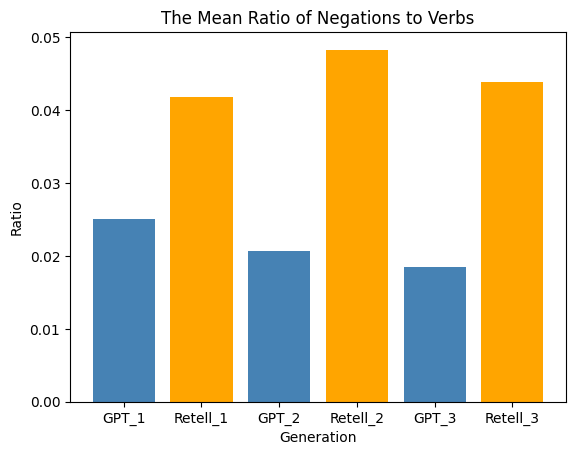

In [333]:
adv_ratio
plt.bar(verbnoun_means['gen'],verbnoun_means['mean'], color=['steelblue','orange'])
plt.title('The Mean Ratio of Negations to Verbs')
plt.xlabel('Generation')
plt.ylabel('Ratio')

## 1.9.1. Statistical Test for Adv/verb  ratios

In [334]:
#Adverb to verb

for i in range(1,4):
    zscore,pvalue = ztest(x1=df[f'Retell_{i}_adv_to_verb_ratio'], x2=df[f'GPT_{i}_adv_to_verb_ratio'], value=0)
    if pvalue < 0.05:
        print(f" Z test for differences in adverb/verb in GPT_R{i}  vs. Retell_{i}  is significant with p-value {pvalue}")
    else:
        print(f" Z test for differences in adverb/verb in GPT_R{i}  vs. Retell_{i}  is not significant with p-value {pvalue}")


 Z test for differences in adverb/verb in GPT_R1  vs. Retell_1  is significant with p-value 0.012301729886706478
 Z test for differences in adverb/verb in GPT_R2  vs. Retell_2  is significant with p-value 0.0008071153738456968
 Z test for differences in adverb/verb in GPT_R3  vs. Retell_3  is significant with p-value 0.004666850011276303


In [335]:
# Adverb to total word count
for i in range(1,4):
    zscore,pvalue = ztest(x1=df[f'Retell_{i}_adv_to_all_words'], x2=df[f'GPT_R{i}_adv_to_all_words'], value=0)
    if pvalue < 0.05:
        print(f" Z test for differences in adverb/all in GPT_R{i}  vs. Retell_{i}  is significant with p-value {pvalue}")
    else:
        print(f" Z test for differences in adverb/all in GPT_R{i}  vs. Retell_{i}  is not significant with p-value {pvalue}")

 Z test for differences in adverb/all in GPT_R1  vs. Retell_1  is significant with p-value 0.0020834907450830754
 Z test for differences in adverb/all in GPT_R2  vs. Retell_2  is significant with p-value 0.0006181933490244548
 Z test for differences in adverb/all in GPT_R3  vs. Retell_3  is significant with p-value 0.0013395350587059724


### 2. Change in Human Adverb/Verb Ratio ( Negation)

In [336]:
for i in range(1,3):
    zscore,pvalue = ztest(x1=df[f'Retell_{i}_adv_to_all_words'], x2=df[f'Retell_{i+1}_adv_to_all_words'], value=0)
    if pvalue < 0.05:
        print(f" Z test for differences in adverb/all in Retell_{i}  vs. Retell_{i+1}  is significant with p-value {pvalue}")
    else:
        print(f" Z test for differences in adverb/all in Retell_{i}  vs. Retell_{i+1}  is not significant with p-value {pvalue}")

 Z test for differences in adverb/all in Retell_1  vs. Retell_2  is not significant with p-value 0.6114841683472254
 Z test for differences in adverb/all in Retell_2  vs. Retell_3  is not significant with p-value 0.7531194162727526


### 2.1. Change in chatGPT Adverb/Verb Ratio ( Negation)

In [337]:
for i in range(1,3):
    zscore,pvalue = ztest(x1=df[f'GPT_R{i}_adv_to_all_words'], x2=df[f'GPT_R{i+1}_adv_to_all_words'], value=0)
    
    if pvalue < 0.05:
        print(f" Z test for differences in adverb/all in GPT_R{i}  vs. GPT_R{i+1}  is significant with p-value {pvalue}")
    else:
        print(f" Z test for differences in adverb/all in GPT_R{i}  vs. GPT_R{i+1}  is not significant with p-value {pvalue}")

 Z test for differences in adverb/all in GPT_R1  vs. GPT_R2  is not significant with p-value 0.6468943808774712
 Z test for differences in adverb/all in GPT_R2  vs. GPT_R3  is not significant with p-value 0.6732808157525589


# 3. Examine Context of Negations

### 3.1. Example from Highly Negated Sentences 

In [338]:
df.columns

Index(['STORY', 'GPT_R1', 'GPT_R2', 'GPT_R3', 'Retell_1', 'Retell_2',
       'Retell_3', 'tokenized_STORY', 'tokenized_GPT_R1', 'tokenized_GPT_R2',
       ...
       'GPT_1_adv_to_verb_ratio', 'GPT_2_adv_to_verb_ratio',
       'GPT_3_adv_to_verb_ratio', 'story_adv_to_verb_ratio',
       'Retell_1_adv_to_all_words', 'Retell_2_adv_to_all_words',
       'Retell_3_adv_to_all_words', 'GPT_R1_adv_to_all_words',
       'GPT_R2_adv_to_all_words', 'GPT_R3_adv_to_all_words'],
      dtype='object', length=133)

### Original


### Get Sentences with High Negations

In [339]:
stories = pd.DataFrame()

stories['stories']=[*df.sort_values(by='story_adv_to_verb_ratio', ascending=False).STORY]
stories['no'] = stories.index

target_df = pd.DataFrame()
target_df['text'] = stories['stories']

In [340]:
stories = pd.DataFrame()

stories['stories']=[*df.sort_values(by='story_adv_to_verb_ratio', ascending=False).STORY]
stories['no'] = stories.index


target_df = pd.DataFrame()
target_df['text'] = stories['stories']
# Create a new column to store the numbers of matching texts
target_df['no'] = ""

# Iterate over the rows of the target DataFrame
for index, row in target_df.iterrows():
    text = row['text']
    
    # Find the index of the text in the original DataFrame
    original_index = stories.index[df['STORY'] == text]
    
    # Check if the text exists in the original DataFrame
    if len(original_index) > 0:
        target_df.at[index, 'no'] = stories.at[original_index[0], 'no']

# Print the updated target DataFrame
print(target_df)

target_df.to_excel('/Users/eotenen/Documents/GitHub/GPT-Retelling-main/GPT/high_negation_original_stories.xlsx')

                                                  text   no
0    The summertime is a season to all -- but not t...   11
1    Christopher settled down in his usual chair at...   24
2    At the age of 43 he made the decision to jump ...  109
3    A person interviewed for a job that they were ...   68
4    A while back I was in a dead end relationship ...   70
..                                                 ...  ...
111  My dog and I took a walk on a path through the...   36
112  It‚'s raining, I just left church and was runn...   35
113  It was a great day. Sally, Mary, Fran and I we...   34
114  It was a beautiful spring day and Jan and Petr...   33
115  A school teacher who taught for high school Ki...    0

[116 rows x 2 columns]


### Retell 1 

In [341]:
[*df.sort_values(by='Retell_1_adv_ratio', ascending=False).Retell_1]

["This poor kid didn't know math well, and his teachers and tutors weren't good at teaching.  The kid is trying but he needs more effective educational tools.",
 "Someone applied for a job that wasn't their dream job. Even though it wasn't their dream job they tried really hard and thought the interview went well, even bought a new shirt and pants and practiced some questions that they thought may be asked. However did not get hired in the end. Oh well, at least it wasn't their dream job.",
 'He was getting ready to sky-dive and he stepped towards the door. He was trying not to feel sick. "Just jump, don\'t think, just jump" he thought. Living like this is much worse than it would be if the parachute didn\'t open. So he jumped and felt complete peace. No fear, just peace. After he hit the ground he began sobbing. He would never be a real man.',
 'Jacob was born with drug addicted mother and an alcoholic father.Jacob was given birth at his home and was not provided best care after his b

In [342]:
[*df.sort_values(by='Retell_1_adv_ratio', ascending=False).GPT_R1]

['A boy struggled with math and studied hard for an important exam with help from a tutor, sacrificing his video game time. Despite his efforts, he only got a passing grade of 70 and was disappointed.',
 'A job seeker prepared for an interview they were hopeful about by buying new clothes, practicing questions, and being well-prepared, but unfortunately they were not hired.',
 'A 43-year-old man took a risk and went skydiving despite his fear. He felt peace as he fell, but after landing he realized he would never be a "real man".',
 'A little boy named Jacob was born to drug-addicted & alcoholic parents. After 6 months, he was removed from their care & placed in a foster family. He was eventually adopted by a loving family but committed suicide at 16 due to unforgiveness towards his birth parents.',
 "A person has a migraine headache and can't visit their sister due to the pain. They contemplate calling their sister but find it too difficult. They're glad it's a Saturday so they don't 

### Retell 2

In [343]:
df.sort_values(by='Retell_2_adv_ratio', ascending=False).Retell_2.iloc[3]

"Jessie was very poor and lived in a store front. He wanted to do something with his life, but wasn't sure what. He had a grandmother who had bad health. He didn't own a car and didn't know how to get a ride anywhere, but was wanting to go somewhere and had interest in pursuing a new love life."

In [344]:
df.sort_values(by='Retell_2_adv_ratio', ascending=False).GPT_R2.iloc[3]

'A young man named Jessie found himself alone when Granny left after taking ill. He discovered an abandoned storefront and decided to make it his new home. Jessie watched as people passed by, realizing he had no one looking for him.'

### Retell 3

In [367]:
df.sort_values(by='Retell_3_adv_ratio', ascending=False).Retell_3.iloc[1]

"Jennifer wanted to go to a punk rock show but she couldn't because she could not get a ticket. She stood outside the venue and waited to see some of the bands. A stranger offered her a ticket and they became friends because the strangers friend did not show up."

In [368]:
df.sort_values(by='Retell_3_adv_ratio', ascending=False).GPT_R3.iloc[1]

'Jennifer missed out on seeing her favorite punk rock show, but she went to the venue anyway. A stranger offered her an extra ticket, and they went to the show together. Jennifer was ecstatic and formed a new friendship with the stranger.'